In [1]:
from PIL import Image, ImageDraw, ImageFilter
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import keras
from keras import Sequential
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Input, Convolution2D,AveragePooling2D,MaxPooling2D,AveragePooling2D,Flatten,Dropout
from keras import optimizers
from tqdm import tqdm
import matplotlib.patches as patches
plt.rcParams["figure.figsize"] = (8,6)
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
model_red=keras.models.load_model('../trained_models/red_10k.h5')
model_blue=keras.models.load_model('../trained_models/blue_10k.h5')
model_white=keras.models.load_model('../trained_models/white_10k.h5')
model_yellow=keras.models.load_model('../trained_models/yellow_10k.h5')

In [3]:
def plot(X,Y_arr,linewidth=2):
    plt.imshow(X.astype(np.float32))
    p=2*300/100
    c_arr=['b','r','w','y']
    for i in range(len(Y_arr)):
        Y=Y_arr[i]
        c=c_arr[i%4]
        plt.scatter([Y[1]+p,Y[0]-p,Y[1]+p,Y[0]-p],\
                [Y[2]-p,Y[2]-p,Y[3]+p,Y[3]+p],c=c)
        ax = plt.gca()
        ax.add_patch(patches.Rectangle((Y[0]-p,Y[2]-p),Y[1]-Y[0]+2*p,Y[3]-Y[2]+2*p,linewidth=linewidth,edgecolor=c,facecolor='none'))
    return plt

### 2 signs on the same image

In [7]:
im=np.load('../data/blue/image_15.npy')/255
red_pred=model_red.predict(np.array([im]))[0]*300
blue_pred=model_blue.predict(np.array([im]))[0]*300
white_pred=model_white.predict(np.array([im]))[0]*300
yellow_pred=model_yellow.predict(np.array([im]))[0]*300

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/pyplot.py'>

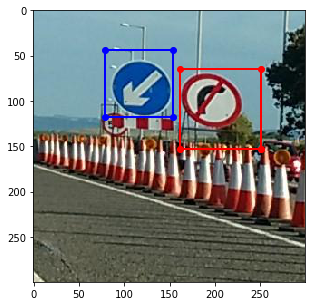

In [8]:
plt.figure(figsize=(5,5))
plot(im,[blue_pred,red_pred])

### Sliding window

In [88]:
def plot(X,Y_arr,color_arr):
    plt.imshow(X.astype(np.float32))
    p=2*300/100
    c_arr=['b','r','w','y']
    for i in range(len(Y_arr)):
        Y=Y_arr[i]
        c=color_arr[i]
        #plt.scatter([Y[1]+p,Y[0]-p,Y[1]+p,Y[0]-p],[Y[2]-p,Y[2]-p,Y[3]+p,Y[3]+p],c=c)
        ax = plt.gca()
        ax.add_patch(patches.Rectangle((Y[0]-p,Y[2]-p),Y[1]-Y[0]+2*p,Y[3]-Y[2]+2*p,linewidth=2,edgecolor=c,facecolor='none'))
    return plt

In [107]:
def proposals(im):
    im=im/255
    r=model_red.predict(np.array([im]))[0]*300
    b=model_blue.predict(np.array([im]))[0]*300
    w=model_white.predict(np.array([im]))[0]*300
    y=model_yellow.predict(np.array([im]))[0]*300
    return [(r,'r'),(w,'w'),(y,'y'),(b,'b')]

In [108]:
classifier=keras.models.load_model('../trained_models/binaryclassifier.h5')

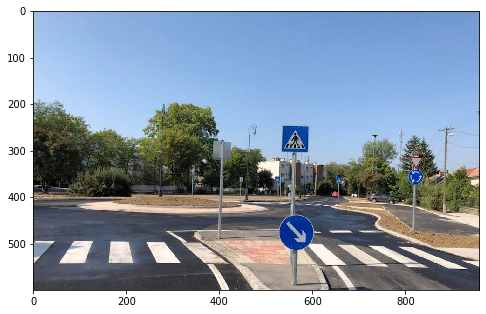

In [109]:
big_im = Image.open("../data/test/big4.jpg")#.crop((400,200,900,600))
plt.imshow(np.array(big_im))

In [110]:
y_size,x_size,_=np.array(big_im).shape

In [111]:
bigprops=[]
bigpreds=[]
for length in max(y_size,x_size)*np.array([.4,.5]):
    for x_top_left in range(0,x_size,int(0.3*length)):
        for y_top_left in range(0,y_size,int(0.3*length)):
            piece=np.array(big_im.crop((x_top_left, y_top_left, x_top_left+length, y_top_left+length)).resize((300,300)))
            props=proposals(piece)
            for colored_proposal in props:
                p=colored_proposal[0]
                c=colored_proposal[1]
                box=[]
                for i in range(4):
                    if i==0 or i==1:
                        box+=[p[i]*length/300+x_top_left]
                    else:
                        box+=[p[i]*length/300+y_top_left]
                if box[1]>x_size or box[3]>y_size:
                    pass
                else:
                    bigprops+=[(box,c)]     
                    window=np.array(big_im)[int(box[2]):int(box[3]),int(box[0]):int(box[1])]
                    window0=np.array(Image.fromarray(window).resize((32,32)))
                    if np.argmax(classifier.predict(np.array([window0])))==0:
                        bigpreds+=[(box,c)]            
                    

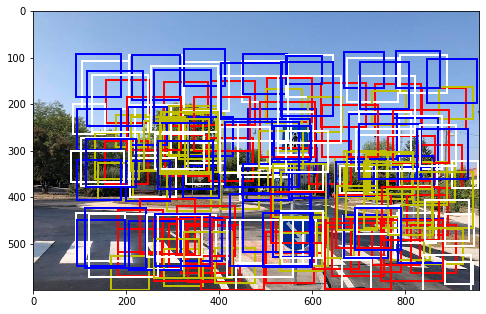

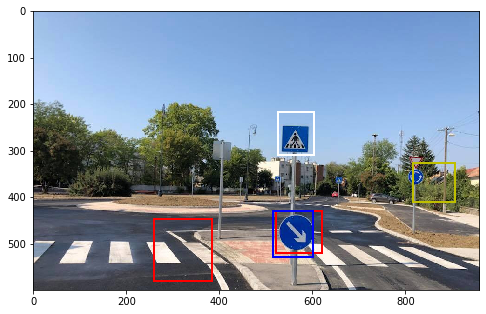

In [112]:
plt.figure(figsize=(8,8))
plot(np.array(big_im)/255,[p[0] for p in bigprops], [p[1] for p in bigprops])
plt.show()
plt.figure(figsize=(8,8))
plot(np.array(big_im)/255,[p[0] for p in bigpreds], [p[1] for p in bigpreds])
plt.show()